In [2]:
import numpy as np
import cv2
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [4]:
import torchvision
import torchvision.models
import torchvision.transforms as transforms

In [5]:
import sklearn.metrics

import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

### Easy way to win Kaggle competetions

In [6]:
submission = pd.read_csv("sample_submission.csv")
submission.label = submission.image_id.apply(lambda x: 0 if x[5:].split()[0][-1] == '6' else 1)
submission.to_csv("leak.csv", index=False)

### Not easy way to win Kaggle competetions

In [7]:
torch.cuda.empty_cache()

In [8]:
DEVICE = "cuda"
BATCH_SIZE = 8

In [9]:
# dataset to prepare raw pictures
def transform(image, dsize=(256, 256), split="train"):
    resized_image = cv2.resize(image, dsize)
    torch_transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    )
    image = torch_transform(resized_image).numpy()

    if split == "train":
        transform = A.Compose([
        A.HorizontalFlip(p=0.3),
        A.RandomBrightness(p=0.3, limit=(-0.35, 0.35)),
        A.RandomRotate90(p=0.3),
        A.Blur(p=0.3, blur_limit=(3, 7)),
        A.Cutout(p=0.3, num_holes=10, max_h_size=10, max_w_size=10)]
        )

        return torch.tensor(transform(image=image)["image"]).float()
    else:
        return torch.tensor(image).float()


class YAW_Dataset(torch.utils.data.Dataset):
    def __init__(self, split="train", transform=transform):
        self.images = os.listdir(split)
        self.transform = transform
        self.split = split
        if self.split == "train":
            self.train_labels = pd.read_csv("train.csv")

    def get_image(self, path):
        image = cv2.imread(self.split + "/" + path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.zeros_like(image)
        for i in range(3):
            image[:, :, i] = gray
        if self.transform is not None:
            image = self.transform(image, split=self.split)
        return image.reshape(3, 256, 256).float()

    def __getitem__(self, index):
        assert(self.split in ["train", "test"])
        if self.split == "train":
            sample = self.train_labels.iloc[index, :]
            image = self.get_image(sample.image_id[6:])
            label = sample.label
            return image, label
        if self.split == "test":
            image = self.get_image(self.images[index])
            return image, self.images[index]

    def __len__(self):
        return len(self.images)

In [10]:
train_dataset = YAW_Dataset(split="train")

In [11]:
# train-test split for validation purposes
train, val = torch.utils.data.random_split(train_dataset,[len(train_dataset)-500, 500])

full_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
#  our model
class ModelVGG(nn.Module):
    def __init__(self, vgg_model):
        super().__init__()
        self.vgg = vgg_model

        self.fc = nn.Linear(1000, 256)
        self.fc_2 = nn.Linear(256, 1)

        self.dropout = nn.Dropout(0.3)
        
    def forward(self, inputs):
        x = F.relu(self.vgg(inputs))
        x = F.relu(self.fc(self.dropout(x)))
        x = self.fc_2(x)
        
        return torch.sigmoid(x)

In [13]:
#  fine-tuning (or not) vgg (or not)
vgg = torchvision.models.resnet101(pretrained=True)

for i, pair in enumerate(vgg.named_children()):
    _, child = pair
    if len(list((vgg.named_children()))) - i > 4:
        for _, params in child.named_parameters():
            params.requires_grad = False

In [14]:
model = ModelVGG(vgg).to(DEVICE)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

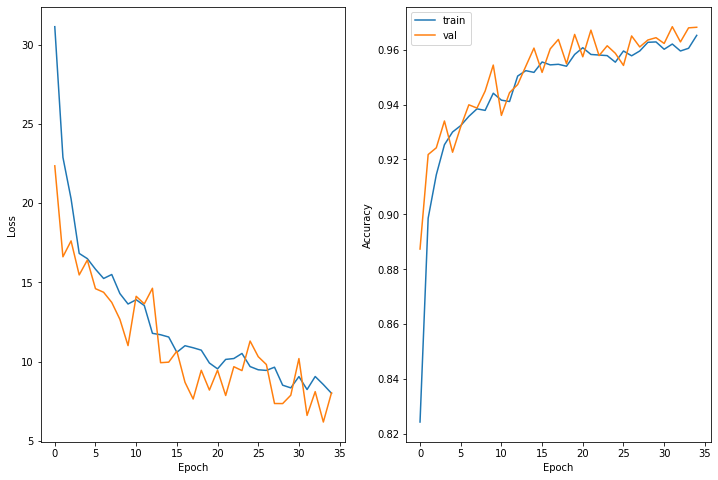

In [15]:
# training (not performing training on full data here)
loss_history = []
acc_history = []
loss_val_history = []
acc_val_history = []

max_loss = np.inf
for epoch in range(35):
    loss_accum = 0
    acc_accum = 0
    model.train()
    for batch in tqdm.notebook.tqdm(train_loader):

        images, labels = batch

        optimizer.zero_grad()
        output = model(images.to(DEVICE))
        loss = criterion(output.cpu().flatten(), labels.float())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        loss_accum += loss.cpu().detach()/BATCH_SIZE
        acc_accum += sklearn.metrics.accuracy_score(np.where(output.cpu().detach().numpy() < 0.5, 0, 1), labels)
        
    loss_history.append(loss_accum)
    acc_history.append(acc_accum/len(train_loader))
    loss_accum = 0
    acc_accum = 0

    for val_batch in tqdm.notebook.tqdm(val_loader):
        images, labels = val_batch
        output = model(images.to(DEVICE))
        loss = criterion(output.cpu().flatten(), labels.float())

        loss_accum += loss.cpu().detach()/BATCH_SIZE
        acc_accum += sklearn.metrics.accuracy_score(np.where(output.cpu().detach().numpy() < 0.5, 0, 1), labels)

    loss_val_history.append(loss_accum)
    acc_val_history.append(acc_accum/len(val_loader))

    clear_output(True)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

    ax[0].plot(loss_history, label='train loss')
    ax[0].plot(loss_val_history, label='validation loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel(f'Epoch')

    ax[1].plot(acc_history, label='train')
    ax[1].plot(acc_val_history, label='val')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel(f'Epoch')

    plt.legend()
    plt.show()


    if loss_val_history[-1] < max_loss:
        max_loss = loss_val_history[-1]
        torch.save(model.state_dict(), 'best_val_model.pt')
    torch.save(model.state_dict(), 'best_val_model.pt')

In [16]:
model.load_state_dict(torch.load('best_val_model.pt'))
for epoch in range(10):
    model.train()
    for batch in tqdm.notebook.tqdm(full_loader):

        images, labels = batch

        optimizer.zero_grad()
        output = model(images.to(DEVICE))
        loss = criterion(output.cpu().flatten(), labels.float())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
                

In [17]:
torch.cuda.empty_cache()

In [18]:
test_dataset = YAW_Dataset(split="test")
test_test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
# model.to("cpu")
model.eval()
labels = []
for batch in tqdm.tqdm(test_test):
    images, path_name = batch
    output = model(images.to(DEVICE))

    labels.extend(zip(path_name, list(map(lambda x: x[0], np.where(output.cpu().detach().numpy() < 0.5, 0, 1).tolist()))))

100%|██████████| 368/368 [00:11<00:00, 31.65it/s]


In [20]:
submission = pd.DataFrame(labels, columns=["image_id", "label"])
submission.image_id = submission.image_id.apply(lambda x: "test\\" + x)

In [21]:
submission.head()

,image_id,label
0,test\123456 (3916).jpg,1
1,test\123456 (1181).jpg,1
2,test\1234567 (109).jpg,1
3,test\1234567 (334).jpg,0
4,test\1234567 (763).jpg,1


In [22]:
submission.to_csv("new_submission.csv", index=False)